In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import os
import numpy as np
import cv2
import pandas as pd  # Import pandas
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset directory
dataset_dir = '/content/drive/My Drive/suma/archive/kvasir-dataset'

# Define function to get data categories
def get_data_categories(dataset_dir):
    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(os.listdir(os.path.join(dataset_dir, folder_name)))
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)
    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_data_categories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"category": categories, "number_of_files": nbr_files})
print("Number of categories:", len(categories))
print(df)


Number of categories: 8
                 category number_of_files
0      dyed-lifted-polyps             500
1  dyed-resection-margins             500
2             esophagitis             500
3            normal-cecum             500
4          normal-pylorus             500
5           normal-z-line             500
6                  polyps             500
7      ulcerative-colitis             500


In [ ]:

# Define function to create dataset
def create_dataset(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_resize_rgb = cv2.resize(img_array, (img_wid, img_high))
                X.append(img_resize_rgb)
                y.append(class_num)
            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y

# Define image dimensions
img_wid, img_high = 100, 100

# Create dataset
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# One-hot encode the labels
num_classes = len(categories)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


X shape: (4000, 100, 100, 3)
y shape: (4000,)
X_train shape: (3200, 100, 100, 3)
y_train shape: (3200,)
X_test shape: (800, 100, 100, 3)
y_test shape: (800,)
X_train shape: (2400, 100, 100, 3)
y_train shape: (2400,)
X_val shape: (800, 100, 100, 3)
y_val shape: (800,)


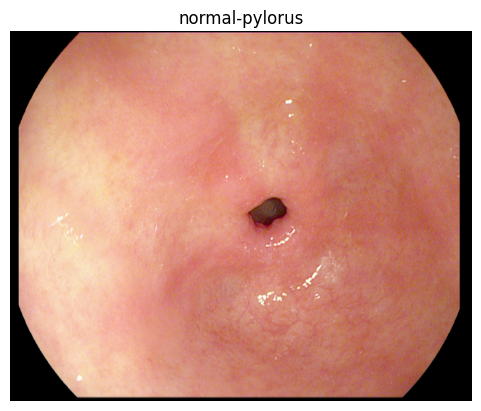

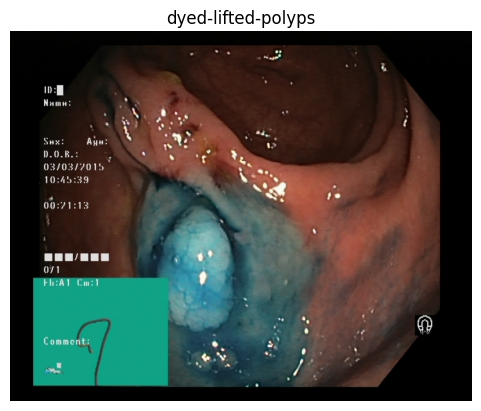

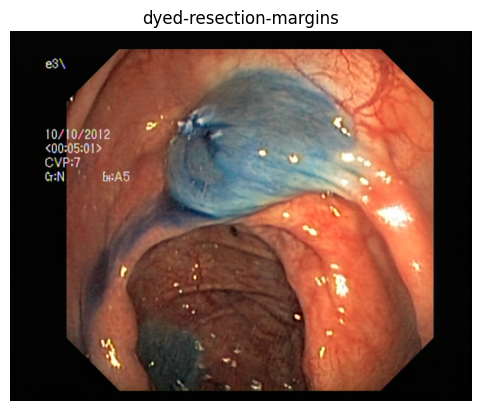

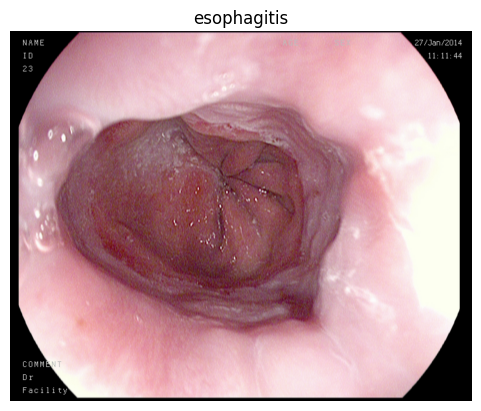

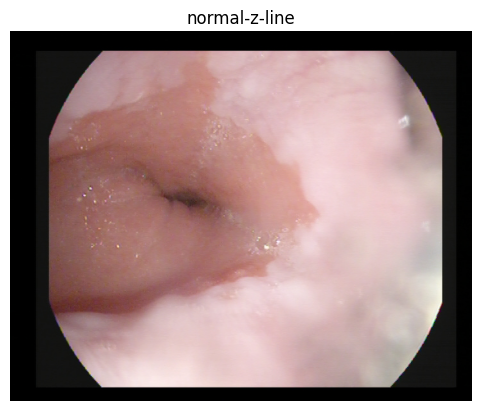

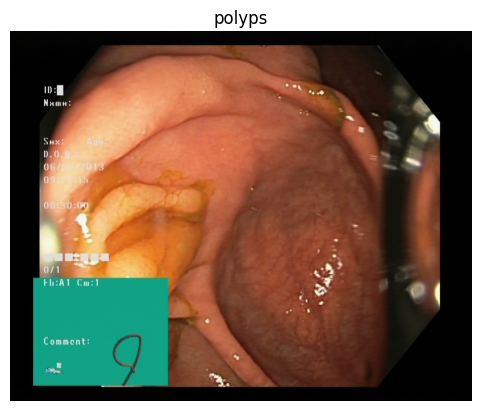

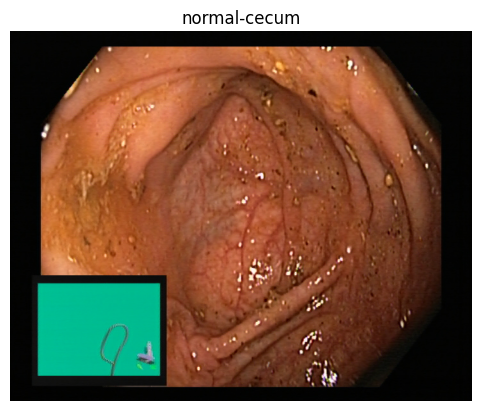

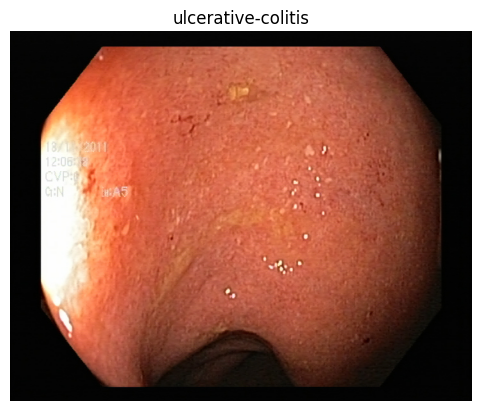

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the dataset directory
dataset_dir = '/content/drive/My Drive/suma/archive/kvasir-dataset'

# Function to get a single image from each subfolder
def display_single_image_from_each_subfolder(dataset_dir):
    for folder_name in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder_name)
        if os.path.isdir(folder_path):
            # Get the first image file in the subfolder
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if len(image_files) > 0:
                image_path = os.path.join(folder_path, image_files[0])
                # Read the image using OpenCV
                image = cv2.imread(image_path)
                # Convert BGR to RGB (OpenCV reads images in BGR format)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Display the image
                plt.imshow(image)
                plt.title(folder_name)
                plt.axis('off')
                plt.show()

# Display a single image from each subfolder
display_single_image_from_each_subfolder(dataset_dir)


In [ ]:

# Define image data augmentation
train_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=0.1)
val_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=0.1)
test_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=0.1)

# Fit augmentation to the data
train_datagen.fit(X_train)
val_datagen.fit(X_val)
test_datagen.fit(X_test)


In [ ]:
# Define the ResNet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet50 model pretrained on ImageNet without including the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_wid, img_high, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(512, activation='relu')(x)

# Add a logistic layer (output layer) with the number of classes
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=20, 
    validation_data=val_datagen.flow(X_val, y_val),
    steps_per_epoch=len(X_train) / 32,
    validation_steps=len(X_val) / 32
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_datagen.flow(X_test, y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
75/75 [==============================] - 141s 2s/step - loss: 0.9503 - accuracy: 0.7017 - val_loss: 0.5135 - val_accuracy: 0.7725
Epoch 2/20
75/75 [==============================] - 130s 2s/step - loss: 0.4669 - accuracy: 0.8062 - val_loss: 0.5109 - val_accuracy: 0.8025
Epoch 3/20
75/75 [==============================] - 120s 2s/step - loss: 0.4063 - accuracy: 0.8292 - val_loss: 0.3989 - val_accuracy: 0.8300
Epoch 4/20
75/75 [==============================] - 125s 2s/step - loss: 0.3774 - accuracy: 0.8462 - val_loss: 0.5542 - val_accuracy: 0.7738
Epoch 5/20
75/75 [==============================] - 125s 2s/step - loss: 0.3517 - accuracy: 0.8471 - val_loss: 0.4919 - val_accuracy: 0.8087
Epoch 6/20
75/75 [==============================] - 118s 2s/step - loss: 0.3357 - accuracy: 0.8633 - val_loss: 0.4248 - val_accuracy: 0.8163
Epoch 7/20
75/75 [==============================] - 133s 2s/step - loss: 0.3035 - accurac

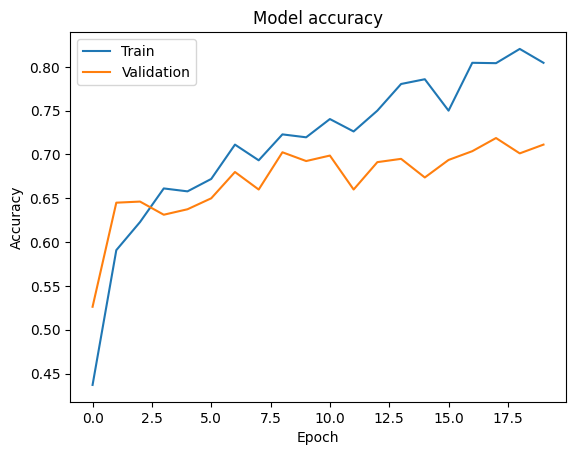

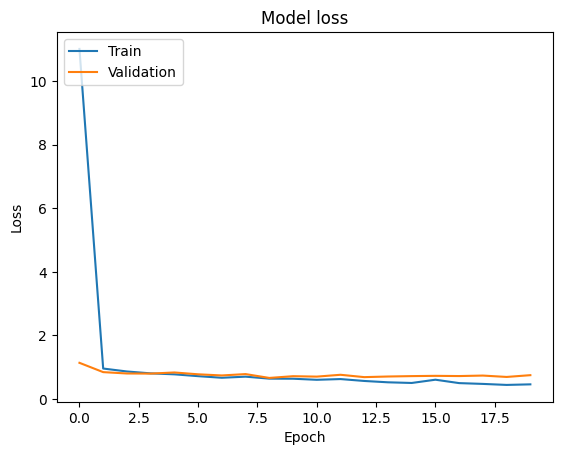

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


25/25 [==============================] - 41s 2s/step


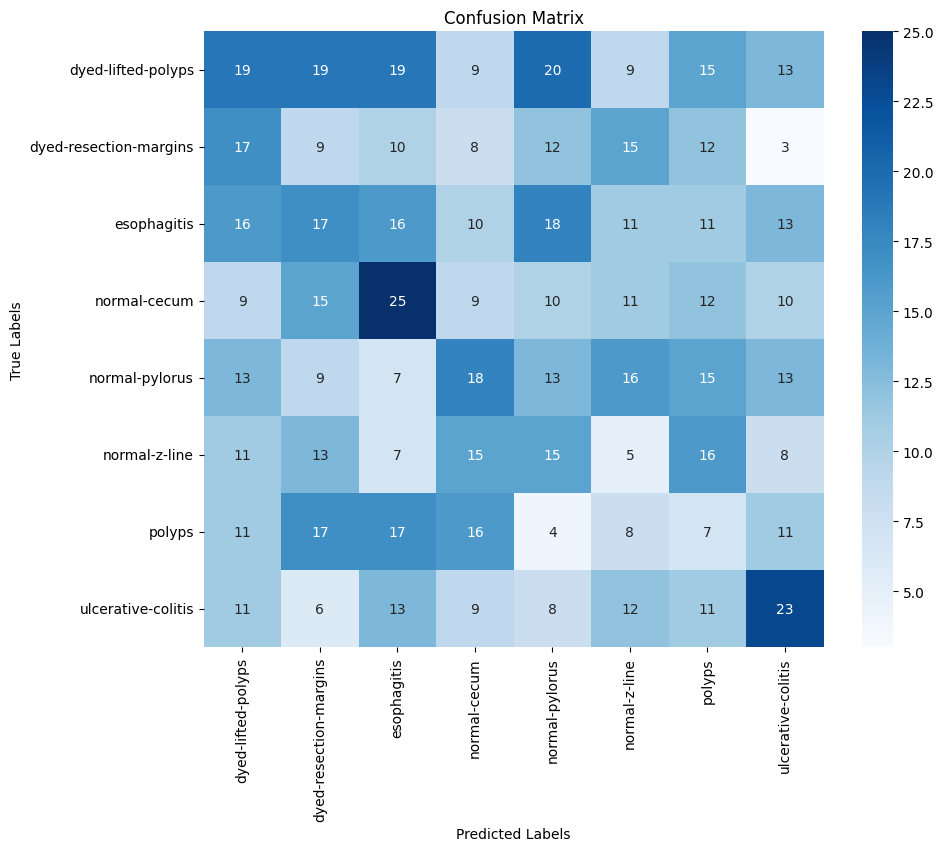

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test set
y_pred = model.predict(test_datagen.flow(X_test, y_test)).argmax(axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = y_test.argmax(axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
